# Pre-Alignment Summary (Strandedness)

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd
from IPython import display

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-04-17 
Git hash: d016341af9f7e0bf172fb8dbe9e83813da94ce03


In [2]:
# Notebook specific imports
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from pymongo import MongoClient

There are a number of protocols for next generation sequencing. Some of these protocols maintain strand information. Reads generated from the Illumina stranded protocol, will align to the opposite strand as the annotated gene. The concept of strandedness is important to properly run aligners and counting algorithms. Luckily, this information is easily available by aligning the reads and see which strand they typically map to. If reads mostly map to the opposite strand of the annotation (like Illumina) then we say they are `Second` strand reads. If they map to the same strand as the annotation then they are `First` strand reads. If they map equally to both strands regardless of annotation then they are `Unstranded` reads.

In [3]:
# Connect to DB
client = MongoClient(host='128.231.83.74', port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [79]:
# Figure numbers
figSeBar = 1
figSeHist = 2
figPeBar = 3
figPeHist = 4

## Single-End

In [74]:
# Import infer_experiment data
infer = pd.read_table('../../output/prealignment/agg/se_inferExperiment.tsv', index_col=0)

# Make sure evertyhing is there
num_rows = infer.shape[0]
assert num_rows == 22740

# Make sure the columns are in the right order and rename
assert infer.columns.tolist() == ['Fraction of reads failed to determine',
                                  'Fraction of reads explained by "++,--"',
                                  'Fraction of reads explained by "+-,-+"']

infer.columns = ['Undetermined', 'First', 'Second']

First I look at SE reads. RSeqQC Infer experiment identifies reads that map to the `First` strand as the annotation ('++,--') or to the `Second` strand ('+-,-+'). It also identifies reads whose orientation could not be determined, because of annotations on both strands. When a library is unstranded reads map equally to both strands. When a library is stranded, it is biased heavily towards either the `First` or `Second` strand. **Figure {{ figSeBar}}.** shows {{ '{:,}'.format(num_rows) }} single-end SRRs on the X-axis and the fraction of reads mapping on the Y-axis. SRRs are sorted, so blocks of similar samples represent projects. The majority of SRRs are `Unstranded`, having about 50% of reads mapping to the `First` strand (green) and 50% of reads mapping to the `Second` strand (red). There are clear sets of SRRs that are stranded, mapping more than 75% of the time to the `First` strand or to the `Second` strand.

To determine a useful cutoff, I look at the distribution of SRRs with different fractions mapping to the `Second` strand (**Figure {{ figSeHist }}**). Note that distribution mapping to the `First` strand is just the mirror image. Setting a quartile threshold (i.e., 25% and 75%) is a simple way to annotate stranded libraries.

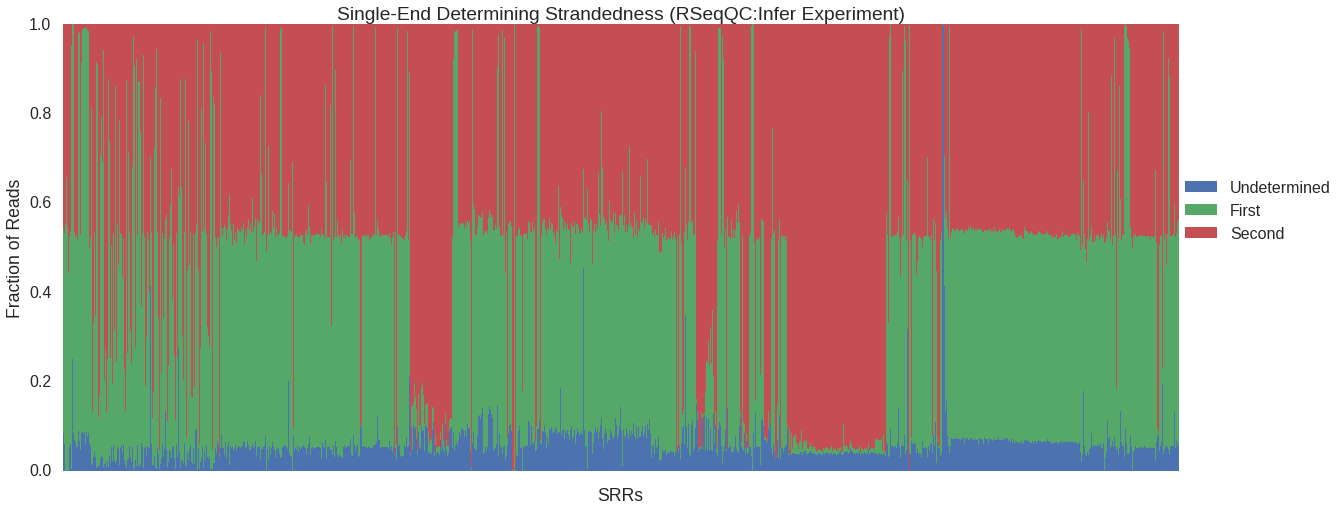

In [75]:
# Figure of Stranded and Unstranded.
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
infer.sort_index().plot.bar(ylim=(0, 1), stacked=True, legend=False, width=1.0, ax=ax, linewidth=0)
ax.legend(loc=(1, .5))
ax.set_title('Single-End Determining Strandedness (RSeqQC:Infer Experiment)')
ax.set_xticklabels([]);
ax.set_xlabel('SRRs')
ax.set_ylabel('Fraction of Reads');

**Figure {{ figSeBar }}. Determining strandedness in single-end reads.** For each single-end SRR, the fraction of reads mapping to the First or Second strand are shown as a stacked bar graph. SRRs that are unstranded have around 50% of reads mapping to the First strand (green) and 50% of reads mapping to the Second strand (red).

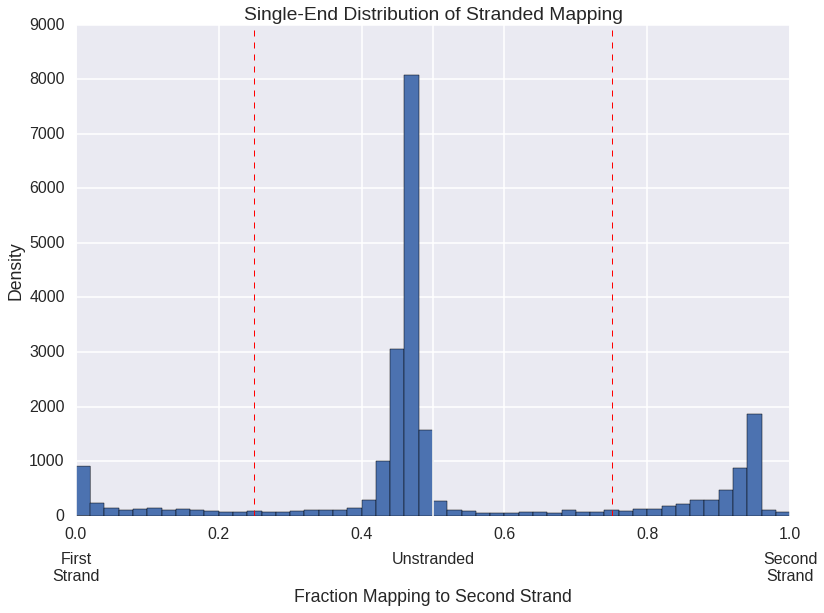

In [76]:
# Plot distribution of fraction mapping
ax = infer['Second'].hist(bins=50)
ax.set_title('Single-End Distribution of Stranded Mapping')
ax.set_ylabel('Density')
ax.axvline(0.25, color='r', ls='--', lw=1)
ax.axvline(0.75, color='r', ls='--', lw=1)

# Add a second Axis for labels
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels(['First\nStrand', 'Unstranded', 'Second\nStrand'], ha='center')
ax2.set_xlabel('Fraction Mapping to Second Strand');

**Figure {{ figSeHist }}. Single-end distribution of the fraction of reads mapping to the second strand.** SRRs fall into one of three categories. First stranded SRRs have the fraction of reads map to the second strand near 0. Unstranded SRRs have the fraction of reads mapping to the second strand near 0.50. Second stranded SRRs have the fraction of reads mapping to the second strand near 1. Dashed red lines indicate the 25% and 75% quartiles.

In [77]:
# number stranded at quartile threshold
first = infer[infer['Second'] < 0.25].index.tolist()
second = infer[infer['Second'] > 0.75].index.tolist()
unstrand =  infer[~infer.index.isin(first + second)].index.tolist()
num_first = len(first)
num_second = len(second)
num_un = len(unstrand)

print('''\
Number Well Stranded Runs (Quartile threshold):
\tFirst strand:\t\t{num_first:,}
\tSecond strand:\t{num_second:,}

Number Unstranded runs:\t{num_un:,}'''.format(num_first=num_first, num_second=num_second, num_un=num_un))

Number Well Stranded Runs (Quartile threshold):
	First strand:		2,003
	Second strand:	4,993

Number Unstranded runs:	15,744


In [100]:
# Update Database
for srr in first:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'first_strand'}})
    
for srr in second:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'second_strand'}})
    
for srr in unstrand:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'unstranded'}})

## Pair-end

In [101]:
# Import infer_experiment data
infer = pd.read_table('../../output/prealignment/agg/pe_inferExperiment.tsv', index_col=0)

# Make sure evertyhing is there
num_rows = infer.shape[0]
assert num_rows == 9257

# Make sure the columns are in the right order and rename
assert infer.columns.tolist() == ['Fraction of reads failed to determine',
                                  'Fraction of reads explained by "1++,1--,2+-,2-+"',
                                  'Fraction of reads explained by "1+-,1-+,2++,2--"']

infer.columns = ['Undetermined', 'First', 'Second']

Pair-end reads are a little different than single ended reads. Namely, the second read (r2) is mapped on the opposite strand from the first read (r1). Therefore instead of just looking for ('++,--') or ('+-,-+') we also need to make sure the r2 is also on the right strand. `First` stranded reads would look like ('1++,1--,2+-,2-+') and `Second` strand reads would look like ('1+-,1-+,2++,2--'). There are only {{ '{:,}'.format(num_rows) }} pair-end samples. Similar to the single-end data, the majority of samples are unstranded.

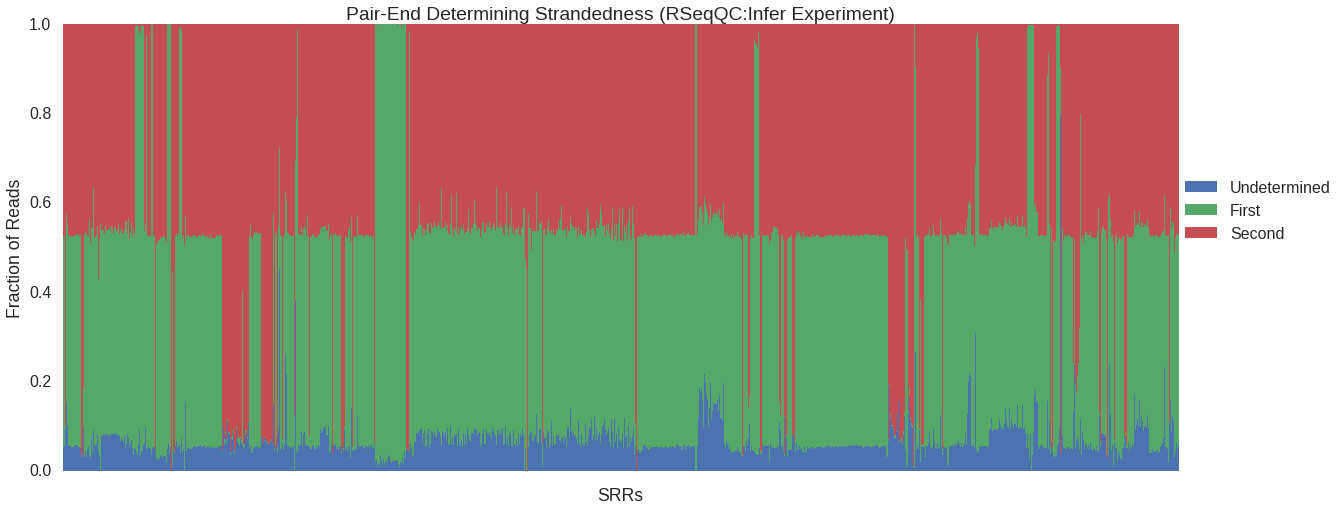

In [102]:
# Figure of Stranded and Unstranded.
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
infer.sort_index().plot.bar(ylim=(0, 1), stacked=True, legend=False, width=1.0, ax=ax, linewidth=0)
ax.legend(loc=(1, .5))
ax.set_title('Pair-End Determining Strandedness (RSeqQC:Infer Experiment)')
ax.set_xticklabels([]);
ax.set_xlabel('SRRs')
ax.set_ylabel('Fraction of Reads');

**Figure {{ figPeBar }}. Determining strandedness in pair-end reads.** For each pair-end SRR, the fraction of reads mapping to the First or Second strand are shown as a stacked bar graph. SRRs that are unstranded have around 50% of reads mapping to the First strand (green) and 50% of reads mapping to the Second strand (red).

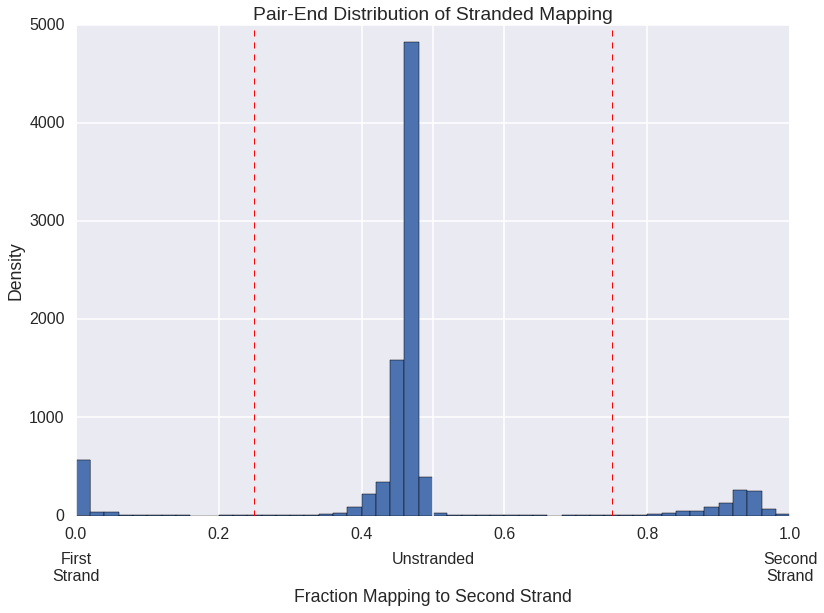

In [103]:
# Plot distribution of fraction mapping
ax = infer['Second'].hist(bins=50)
ax.set_title('Pair-End Distribution of Stranded Mapping')
ax.set_ylabel('Density')
ax.axvline(0.25, color='r', ls='--', lw=1)
ax.axvline(0.75, color='r', ls='--', lw=1)

# Add a second Axis for labels
ax2 = ax.twiny()
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.set_xticks([0, 0.5, 1])
ax2.set_xticklabels(['First\nStrand', 'Unstranded', 'Second\nStrand'], ha='center')
ax2.set_xlabel('Fraction Mapping to Second Strand');

**Figure {{ figPeHist }}. Pair-end distribution of the fraction of reads mapping to the second strand.** SRRs fall into one of three categories. First stranded SRRs have the fraction of reads map to the second strand near 0. Unstranded SRRs have the fraction of reads mapping to the second strand near 0.50. Second stranded SRRs have the fraction of reads mapping to the second strand near 1. Dashed red lines indicate the 25% and 75% quartiles.

In [105]:
# number stranded at quartile threshold
first = infer[infer['Second'] < 0.25].index.tolist()
second = infer[infer['Second'] > 0.75].index.tolist()
unstrand =  infer[~infer.index.isin(first + second)].index.tolist()
num_first = len(first)
num_second = len(second)
num_un = len(unstrand)

print('''\
Number Well Stranded Runs (Quartile threshold):
\tFirst strand:\t\t{num_first:,}
\tSecond strand:\t{num_second:,}

Number Unstranded runs:\t{num_un:,}'''.format(num_first=num_first, num_second=num_second, num_un=num_un))

Number Well Stranded Runs (Quartile threshold):
	First strand:		674
	Second strand:	962

Number Unstranded runs:	7,621


In [106]:
# Update Database
for srr in first:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'first_strand'}})
    
for srr in second:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'second_strand'}})
    
for srr in unstrand:
    remap.update_one({'runs.srr': srr}, {'$addToSet': {'runs.$.pre_aln_flags': 'unstranded'}})